# Pacchetti

In [1]:
import pyBspline as Bs
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
#import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import scipy
from scipy.misc import derivative
from scipy.optimize import curve_fit
import pandas as pd
#from ipywidgets import interactive
#import ipywidgets as widgets
#from ipywidgets import AppLayout, FloatSlider
#from mpl_toolkits.mplot3d import Axes3D
import copy
import pandas as pd
#from scipy import integrate
#import itertools 
#import time
import os
import scipy.special
import re
import scipy.integrate
#
#import FFT as esFFT

###
def norm(x):
    return np.sqrt(np.sum(np.power(x,2.0)))        
      

[NbConvertApp] Converting notebook pyBspline.ipynb to script
[NbConvertApp] Writing 83345 bytes to pyBspline.py


In [2]:
def plot(fig,n,xB,yB,x,y,c,title,cmap):
    
    ax = fig.add_subplot(n)
    ax.plot(xB, yB, color= "black",label="Bspline")
    sc = ax.scatter(x,y,c=c,cmap=cmap)
    plt.colorbar(sc)
    ax.set_aspect('equal')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.title(title)
    
    return

In [3]:
def plot_sol(fig,n,xB,yB,x,y,c,title):
    
    ax = fig.add_subplot(n)
    ax.plot(xB, yB, color= "black",label="Bspline")
    sc = ax.scatter(x,y,c=c,cmap=cmap)
    plt.colorbar(sc)
    ax.set_aspect('equal')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.title(title)
    
    return

# Triangle

## Definition

In [4]:
k_in = 20*np.asarray([0.5,np.sqrt(3)/2])
wavevector = np.sqrt(np.sum(np.power(k_in,2.0)))
I = np.complex(0,1)

xmin = -1.5
xmax = 1.5
ymin = -1.5
ymax = 1.5

In [5]:
#definisco la dimensionaità:
sh = Bs.shape(1,2)
#sh.show()

#defiisco i knot vector
P=1 #polinomial degree
N=100 #base caridnality
xminBs = 0.0
xmaxBs = 1.0


#
#kv = Bs.uniform_open_kv(xmin,xmax,p=P,n=N)#Bs.knot_vector(P,N,v)
#kv = periodic_kv(xmin,xmax,p=P,n=N)
kv = Bs.periodic_kv(xminBs,xmaxBs,p=P,n=N)
#kv.show()

#alloco la Bspline
bs = Bs.Bspline(sh,[kv],properties={"periodic":[True]})

In [6]:
file_dir = "files/BEM/triangle-periodic/"
suffix = "P="+str(P)+"-N="+str(N)+"-k="+str(wavevector)+".csv"
suffix_png = "P="+str(P)+"-N="+str(N)+"-k="+str(wavevector)+".png"

## Geometry

In [7]:
#
x0 = -0.5
y0 =  -0.5

a = 1.0 / (2+np.sqrt(2))
b = (1.0+np.sqrt(2)) / (2+np.sqrt(2))
delta = b-a

sx = 1.0
sy = 1.0

def triangle_x(i):
    if i <= a :
        return i
    elif i > a and i <= b :
        j = i-a
        return a - j*a/(delta)
    else :
        return 0
    
def triangle_y(i):
    if i <= a :
        return 0
    elif i > a and i <= b :
        j = i-a
        return j*a/(delta)
    else :
        j = i-b
        return a-j
    
def func(t):
    out = np.zeros((len(t),2))
    out[:,0] = [triangle_x(i) for i in t]
    out[:,1] = [triangle_y(i) for i in t]
            
    out[:,0] = sx*out[:,0]/a+x0
    out[:,1] = sy*out[:,1]/a+y0
    return out

In [8]:
#ATTENZIONE: mi servono dei punti distribuiti in modo uniforme
# per come ho costruito func so che
# func(0.) = func(1.)
# quindi genero un punto in più
t = np.linspace(0,1,N+1,endpoint=True)#[0:-2]
cp = func(t)
for i in range(len(t)):
    #bs._cp[i] = cp[i]
    bs.set_cp(i,cp[i])
cpx = cp[:,0]
cpy = cp[:,1]

In [9]:
#
NN = 1000
T = np.linspace(xminBs,xmaxBs,NN,endpoint=True)
xy   = bs.evaluate(T)
Txy = func(T)
df = pd.DataFrame(xy)
df = df.rename(columns={0:"x",1:"y"})

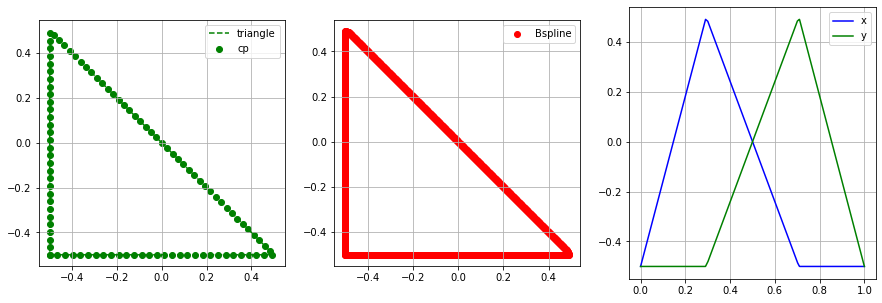

In [10]:
fig = plt.figure ( 0 , figsize = ( 15, 5 ) )

#converto in dataframe    
ax = fig.add_subplot(131)
plt.plot(Txy[:,0],Txy[:,1],color="green",label="triangle",linestyle="--")
plt.scatter(cpx,cpy,color="green",label="cp")
#plt.scatter(df["x"], df["y"], color= "red",label="Bspline")
plt.grid()
plt.legend()
ax.set_aspect('equal')

ax = fig.add_subplot(132)
#plt.plot(cpx,cpy,color="green",label="cp",linestyle="--")
#plt.scatter(cpx,cpy,color="green",label="cp")
plt.scatter(df["x"], df["y"], color= "red",label="Bspline")
plt.grid()
plt.legend()
ax.set_aspect('equal')

#real
ax = fig.add_subplot(133)#, projection='3d')
ax.plot(T,df["x"],color="blue",label="x")
ax.plot(T,df["y"],color="green",label="y")
#ax.plot(df["t"],np.real(df["trace"]),color="red",label="trace")
#plt.title("real")
plt.grid(True)
plt.legend()
plt.show()

## Stiffness Matrix

In [11]:
file = file_dir+"stiffness_matrix-n=6-random=False-"+suffix
file

'files/BEM/triangle-periodic/stiffness_matrix-n=6-random=False-P=1-N=100-k=20.0.csv'

In [12]:
READ = True
SAVE = False
if os.path.exists(file) and READ == True :
    sm = bs.load("sm-BEM",file)
else :
    sm,out = bs.stiffness_matrix_BEM(k=wavevector,\
                opts={"print":True,"N":[6],"return_both":True,"ready_sm_BEM":False,"random":False})
    if SAVE == True :
        bs.save("sm-BEM",file)
sm.head()

,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)","(7,)","(8,)","(9,)",...,"(90,)","(91,)","(92,)","(93,)","(94,)","(95,)","(96,)","(97,)","(98,)","(99,)"
"(0,)",0.000306+0.000282j,0.000118+0.000252j,-0.000057+0.000146j,-0.000112+0.000057j,-0.000106-0.000025j,-0.000059-0.000077j,0.000004-0.000088j,0.000055-0.000061j,0.000076-0.000012j,0.000062+0.000037j,...,0.000024+0.000064j,0.000062+0.000037j,0.000076-0.000012j,0.000055-0.000061j,0.000004-0.000088j,-0.000059-0.000077j,-0.000106-0.000025j,-0.000112+0.000057j,-0.000057+0.000146j,0.000114+0.000234j
"(1,)",0.000118+0.000252j,0.000251+0.000261j,0.000097+0.000235j,-0.000052+0.000110j,-0.000089+0.000038j,-0.000080-0.000025j,-0.000040-0.000063j,0.000008-0.000068j,0.000046-0.000044j,0.000059-0.000004j,...,0.000012+0.000053j,0.000045+0.000036j,0.000061-0.000001j,0.000050-0.000042j,0.000014-0.000069j,-0.000035-0.000068j,-0.000078-0.000034j,-0.000094+0.000024j,-0.000071+0.000090j,-0.000011+0.000145j
"(2,)",-0.000057+0.000146j,0.000097+0.000235j,0.000251+0.000261j,0.000097+0.000235j,-0.000052+0.000110j,-0.000089+0.000038j,-0.000080-0.000025j,-0.000040-0.000063j,0.000008-0.000068j,0.000046-0.000044j,...,0.000007+0.000054j,0.000041+0.000040j,0.000060+0.000007j,0.000055-0.000034j,0.000025-0.000064j,-0.000021-0.000072j,-0.000065-0.000050j,-0.000091-0.000005j,-0.000090+0.000048j,-0.000071+0.000090j
"(3,)",-0.000112+0.000057j,-0.000052+0.000110j,0.000097+0.000235j,0.000251+0.000261j,0.000097+0.000235j,-0.000052+0.000110j,-0.000089+0.000038j,-0.000080-0.000025j,-0.000040-0.000063j,0.000008-0.000068j,...,-0.000002+0.000054j,0.000032+0.000046j,0.000056+0.000018j,0.000060-0.000020j,0.000039-0.000054j,0.000002-0.000072j,-0.000040-0.000066j,-0.000074-0.000040j,-0.000091-0.000005j,-0.000094+0.000024j
"(4,)",-0.000106-0.000025j,-0.000089+0.000038j,-0.000052+0.000110j,0.000097+0.000235j,0.000251+0.000261j,0.000097+0.000235j,-0.000052+0.000110j,-0.000089+0.000038j,-0.000080-0.000025j,-0.000040-0.000063j,...,-0.000014+0.000051j,0.000020+0.000052j,0.000048+0.000032j,0.000061-0.000001j,0.000053-0.000036j,0.000028-0.000063j,-0.000007-0.000073j,-0.000040-0.000066j,-0.000065-0.000050j,-0.000078-0.000034j


In [13]:
#
def plot_matrix(sm,file_png=None):
    #
    sm2 = sm.copy()
    sm2["index"] = sm2.index
    #
    new = sm2.melt(id_vars=['index'])# = sm.index
    #
    new2 = new.copy()
    new2["index"] = [ i[0] for i in new2["index"]]
    new2["variable"] = [ i[0] for i in new2["variable"]]
    #new2["value"] = [np.complex(i) for i in new2["value"] ]
    new2["real"] = np.real(new2["value"])
    new2["imag"] = np.imag(new2["value"])
    new2["abs"] = np.absolute(new2["value"])
    new2["phase"] = np.angle(new2["value"])/np.pi
    df = new2
    
    #
    fig = plt.figure ( 0 , figsize = ( 15 , 10 ) )

    cmap = 'RdYlBu'

    #
    ax = fig.add_subplot(221)
    sc = ax.scatter(df["index"],df["variable"],c=df["real"],cmap = 'RdYlBu')
    plt.colorbar(sc)
    plt.xlim(min(df["index"]),max(df["index"]))
    plt.ylim(min(df["index"]),max(df["index"]))
    ax.set_aspect('equal')
    plt.title("stiffness matrix : real")

    #
    ax = fig.add_subplot(222)
    sc = ax.scatter(df["index"],df["variable"],c=df["imag"],cmap = 'RdYlBu')
    plt.colorbar(sc)
    plt.xlim(min(df["index"]),max(df["index"]))
    plt.ylim(min(df["index"]),max(df["index"]))
    ax.set_aspect('equal')
    plt.title("stiffness matrix : imag")

    #
    ax = fig.add_subplot(223)
    sc = ax.scatter(df["index"],df["variable"],c=df["abs"],cmap = 'RdYlBu')
    plt.colorbar(sc)
    plt.xlim(min(df["index"]),max(df["index"]))
    plt.ylim(min(df["index"]),max(df["index"]))
    ax.set_aspect('equal')
    plt.title("stiffness matrix : abs")

    #
    ax = fig.add_subplot(224)
    sc = ax.scatter(df["index"],df["variable"],c=df["phase"],cmap = 'RdYlBu')
    plt.colorbar(sc)
    plt.xlim(min(df["index"]),max(df["index"]))
    plt.ylim(min(df["index"]),max(df["index"]))
    ax.set_aspect('equal')
    plt.title("stiffness matrix : $\\theta / \pi$")

    plt.tight_layout()
    if file_png is not None :
        plt.savefig(file_png)
    plt.show()
    

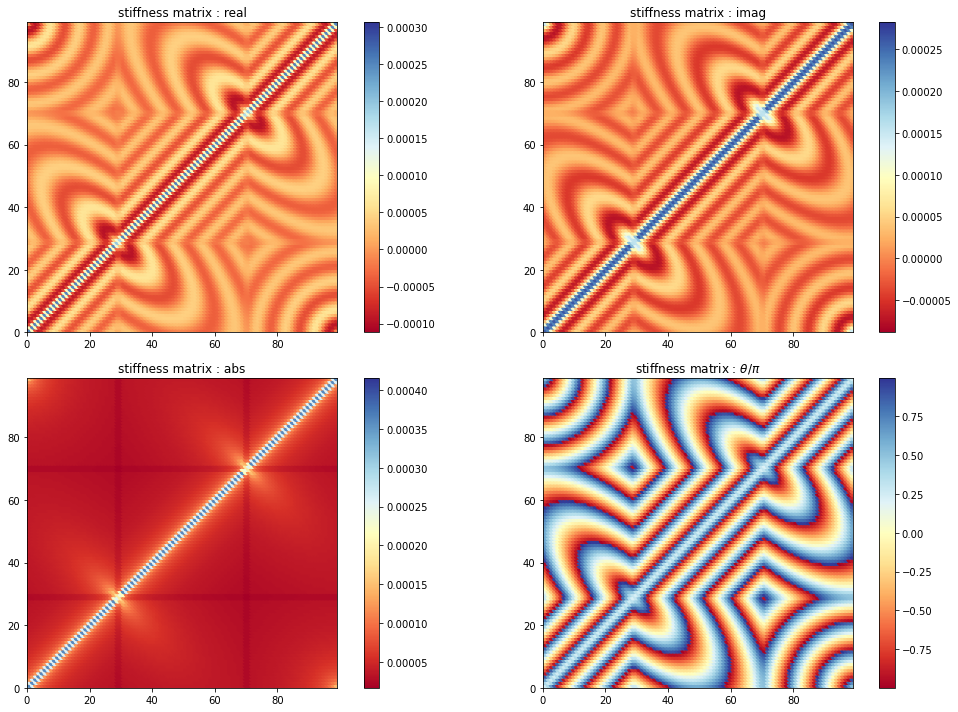

In [14]:
file_png = file_dir+"stiffness_matrix-n=6-random=False-"+suffix_png
plot_matrix(sm,file_png)

## Single Layer Potential basis

In [15]:
file = file_dir+"single_layer_potential-"+suffix
file

'files/BEM/triangle-periodic/single_layer_potential-P=1-N=100-k=20.0.csv'

In [16]:
Nx= int(xmax-xmin)*20
Ny = int(ymax-ymin)*20
x = np.linspace(xmin,xmax,Nx)
y = np.linspace(ymin,ymax,Ny)
X,Y = np.meshgrid(x,y)

XY0 = np.zeros((Nx*Ny,2))
XY0[:,0] = X.reshape((Nx*Ny,))
XY0[:,1] = Y.reshape((Nx*Ny,))

#tolgo elementi interni
#radius = np.asarray([np.sqrt(np.sum(np.power(i,2.0))) for i in XY])
internal = bs.internal_points(XY=XY0,NN=1000,xmin=0.,xmax=1.,opts=None)
XY = XY0[ np.logical_not(internal) ]

In [17]:
READ = True
SAVE = True
if os.path.exists(file) and READ == True :
    slp = bs.load("slp-BEM",file)
#else :

# I can update it adding some  points
slp = bs.single_layer_potential_basis_BEM(XY=XY,k=wavevector,\
                                              opts={"print":True,"N":[6]})
if SAVE == True :
    bs.save("slp-BEM",file)
    
slp.head()

single_layer_potential_basis_BEM


,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)","(7,)","(8,)","(9,)",...,"(90,)","(91,)","(92,)","(93,)","(94,)","(95,)","(96,)","(97,)","(98,)","(99,)"
"(-1.5, -1.5)",-0.000769-0.001009j,-0.000288-0.000955j,0.000198-0.000969j,0.000634-0.000747j,0.000910-0.000340j,0.000950+0.000152j,0.000741+0.000601j,0.000334+0.000884j,-0.000161+0.000923j,-0.000607+0.000703j,...,-0.000876+0.000284j,-0.000607+0.000703j,-0.000161+0.000923j,0.000334+0.000884j,0.000741+0.000601j,0.000950+0.000152j,0.000910-0.000340j,0.000634-0.000747j,0.000198-0.000969j,-0.000288-0.000955j
"(-1.4491525423728813, -1.5)",-0.001256-0.000268j,-0.000859-0.000534j,-0.000509-0.000864j,-0.000041-0.000992j,0.000435-0.000883j,0.000801-0.000557j,0.000962-0.000092j,0.000873+0.000395j,0.000552+0.000772j,0.000084+0.000938j,...,-0.000569+0.000734j,-0.000098+0.000932j,0.000407+0.000853j,0.000798+0.000523j,0.000962+0.000040j,0.000857-0.000459j,0.000514-0.000836j,0.000030-0.000990j,-0.000465-0.000885j,-0.000844-0.000553j
"(-1.3983050847457628, -1.5)",-0.001153+0.000601j,-0.001014+0.000151j,-0.000964-0.000322j,-0.000701-0.000723j,-0.000278-0.000958j,0.000208-0.000966j,0.000642-0.000740j,0.000913-0.000330j,0.000948+0.000162j,0.000734+0.000609j,...,-0.000077+0.000933j,0.000438+0.000837j,0.000824+0.000481j,0.000962-0.000026j,0.000814-0.000531j,0.000426-0.000884j,-0.000089-0.000987j,-0.000584-0.000813j,-0.000922-0.000414j,-0.001016+0.000099j
"(-1.347457627118644, -1.5)",-0.000539+0.001202j,-0.000701+0.000768j,-0.000958+0.000377j,-0.001016-0.000093j,-0.000854-0.000542j,-0.000499-0.000869j,-0.000030-0.000993j,0.000444-0.000878j,0.000807-0.000548j,0.000963-0.000081j,...,0.000429+0.000841j,0.000825+0.000476j,0.000961-0.000045j,0.000794-0.000559j,0.000379-0.000905j,-0.000157-0.000978j,-0.000652-0.000759j,-0.000961-0.000315j,-0.000996+0.000225j,-0.000753+0.000706j
"(-1.2966101694915255, -1.5)",0.000297+0.001300j,-0.000083+0.001050j,-0.000519+0.000906j,-0.000854+0.000583j,-0.001015+0.000141j,-0.000960-0.000332j,-0.000693-0.000730j,-0.000268-0.000961j,0.000219-0.000964j,0.000650-0.000733j,...,0.000802+0.000511j,0.000960-0.000017j,0.000801-0.000547j,0.000377-0.000904j,-0.000174-0.000974j,-0.000677-0.000736j,-0.000975-0.000265j,-0.000978+0.000293j,-0.000687+0.000770j,-0.000191+0.001026j


## Plane wave

### Preparation

In [18]:
Nx= int(xmax-xmin)*20
Ny = int(ymax-ymin)*20
x = np.linspace(xmin,xmax,Nx)
y = np.linspace(ymin,ymax,Ny)
X,Y = np.meshgrid(x,y)

XY0 = np.zeros((Nx*Ny,2))
XY0[:,0] = X.reshape((Nx*Ny,))
XY0[:,1] = Y.reshape((Nx*Ny,))

#tolgo elementi interni
#radius = np.asarray([np.sqrt(np.sum(np.power(i,2.0))) for i in XY])
internal = bs.internal_points(XY=XY0,NN=1000,xmin=0.,xmax=1.,opts=None)
XY = XY0[ np.logical_not(internal) ]

In [19]:
def plane_wave(xx): # soluzione
    xx = np.asarray(xx)
    theta = np.dot(xx,k_in)
    return np.exp(I*theta)

In [20]:
#
NN = 1000
T = np.linspace(xminBs,xmaxBs,NN,endpoint=True)
xy   = bs.evaluate(T)
df = pd.DataFrame(xy)
df = df.rename(columns={0:"x",1:"y"})
uinc = plane_wave(xy)

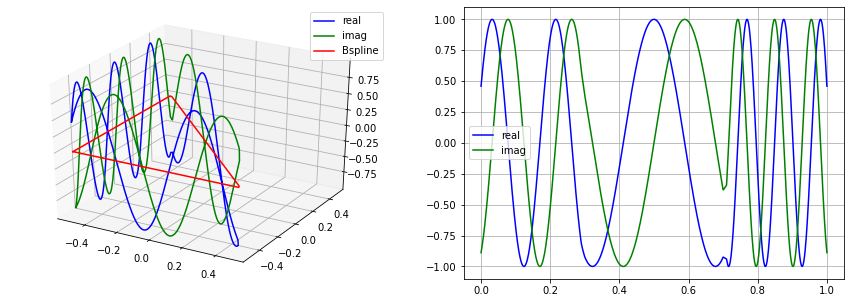

In [21]:
fig = plt.figure ( 0 , figsize = ( 15, 5 ) )

#
#s = 0.2
ax = fig.add_subplot(121, projection='3d')
ax.plot(xy[:,0], xy[:,1],uinc.real,color="blue",label="real")
ax.plot(xy[:,0], xy[:,1],uinc.imag,color="green",label="imag")
ax.plot(xy[:,0], xy[:,1],0.0,color="red",label="Bspline")
plt.grid(True)
plt.legend()

#
ax = fig.add_subplot(122)#, projection='3d')
ax.plot(T,uinc.real,color="blue",label="real")
ax.plot(T,uinc.imag,color="green",label="imag")
plt.grid(True)
plt.legend()

plt.show()

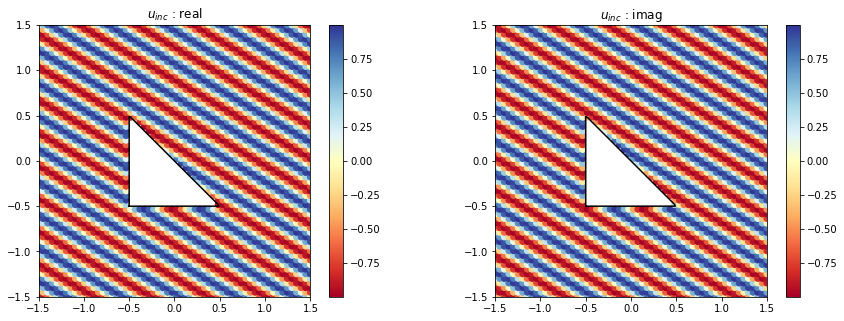

In [22]:
fig = plt.figure ( 0 , figsize = ( 15 , 5 ) )

Uinc = plane_wave(XY)

cmap = 'RdYlBu'
    
plot(fig,121,df["x"], df["y"],XY[:,0],XY[:,1],Uinc.real,"$u_{inc}$ : real",cmap)
plot(fig,122,df["x"], df["y"],XY[:,0],XY[:,1],Uinc.imag,"$u_{inc}$ : imag",cmap)

plt.show()

### Solution

In [23]:
#
file_sol = file_dir+"solution-plane_wave-"+suffix
file_lv  = file_dir+"load_vector-plane_wave-"+suffix
file_ind = file_dir+"indirect_solution-plane_wave-"+suffix
print(file_sol)
print(file_lv)
print(file_ind)

files/BEM/triangle-periodic/solution-plane_wave-P=1-N=100-k=20.0.csv
files/BEM/triangle-periodic/load_vector-plane_wave-P=1-N=100-k=20.0.csv
files/BEM/triangle-periodic/indirect_solution-plane_wave-P=1-N=100-k=20.0.csv


In [24]:
#
READ = False
SAVE = True
if os.path.exists(file_sol) and READ == True :
    sol,Xnp,Valnp = bs.load("sol-BEM",file_sol)
    
if os.path.exists(file_lv) and READ == True :
    lv = bs.load("lv-BEM",file_lv)
    
if os.path.exists(file_ind) and READ == True :
    sol = bs.load("ind_sol-BEM",file_ind)
    
else :
    opts = {"print":True,"ready_sol_BEM":False,"ready_lv_BEM":False,"ready_ind_sol_BEM":False}
    sol,Xnp,Valnp = bs.BEM(uinc=plane_wave,k=wavevector,XY=XY,opts=opts)
    if SAVE == True :
        bs.save("sol-BEM",file_sol)
        bs.save("lv-BEM",file_lv)
        bs.save("ind_sol-BEM",file_ind)
sol.head()

single_layer_potential_basis_BEM


,x,value
"(-1.5, -1.5)","(-1.5, -1.5)",0.102337-0.069129j
"(-1.4491525423728813, -1.5)","(-1.4491525423728813, -1.5)",0.031161-0.119963j
"(-1.3983050847457628, -1.5)","(-1.3983050847457628, -1.5)",-0.053430-0.111722j
"(-1.347457627118644, -1.5)","(-1.347457627118644, -1.5)",-0.110985-0.053444j
"(-1.2966101694915255, -1.5)","(-1.2966101694915255, -1.5)",-0.119590+0.024307j


In [25]:
#
Uinc = plane_wave(XY)#.reshape(Nx,Ny).transpose()
total = Uinc + Valnp

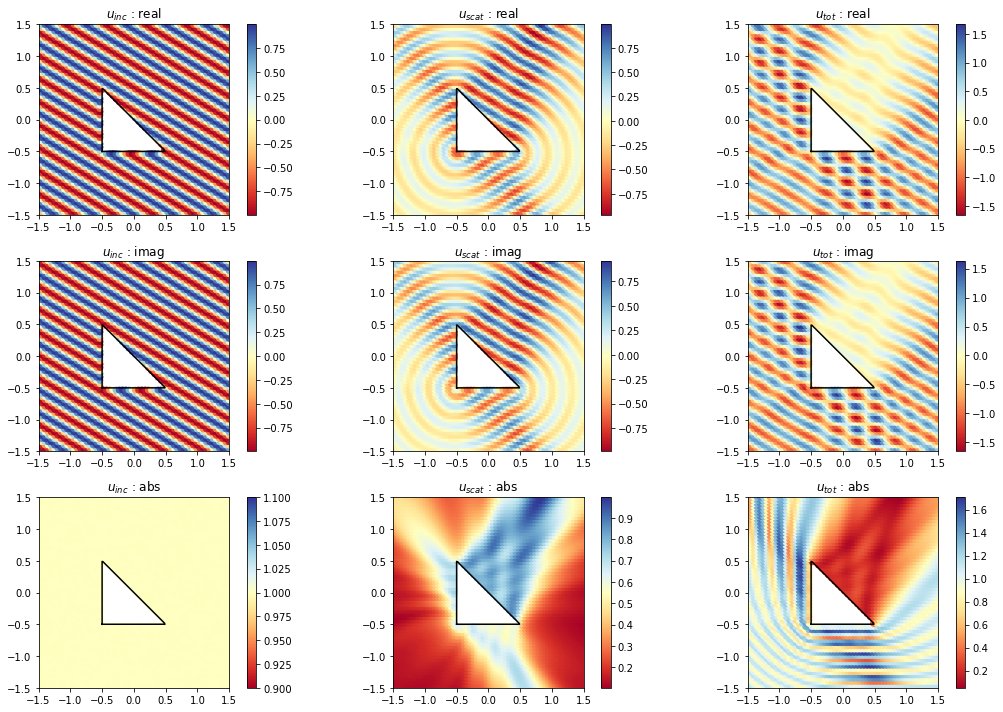

In [26]:
#grafico
fig = plt.figure ( 0 , figsize = ( 15 , 10 ) )

cmap = 'RdYlBu'

    
plot_sol(fig,331,df["x"], df["y"],XY[:,0],XY[:,1],Uinc.real,"$u_{inc}$ : real")
plot_sol(fig,334,df["x"], df["y"],XY[:,0],XY[:,1],Uinc.imag,"$u_{inc}$ : imag")
plot_sol(fig,337,df["x"], df["y"],XY[:,0],XY[:,1],np.absolute(Uinc),"$u_{inc}$ : abs")

plot_sol(fig,332,df["x"], df["y"],XY[:,0],XY[:,1],Valnp.real,"$u_{scat}$ : real")
plot_sol(fig,335,df["x"], df["y"],XY[:,0],XY[:,1],Valnp.imag,"$u_{scat}$ : imag")
plot_sol(fig,338,df["x"], df["y"],XY[:,0],XY[:,1],np.absolute(Valnp),"$u_{scat}$ : abs")

plot_sol(fig,333,df["x"], df["y"],XY[:,0],XY[:,1],total.real,"$u_{tot}$ : real")
plot_sol(fig,336,df["x"], df["y"],XY[:,0],XY[:,1],total.imag,"$u_{tot}$ : imag")
plot_sol(fig,339,df["x"], df["y"],XY[:,0],XY[:,1],np.absolute(total),"$u_{tot}$ : abs")

plt.tight_layout()

sol_png = file_dir+"solution-n=6-random=False-"+suffix_png
plt.savefig(sol_png)

plt.show()

### Trace

In [26]:
file = file_dir+"single_layer_potential-"+suffix
file

'files/BEM/triangle-periodic/single_layer_potential-P=1-N=100-k=20.0.csv'

In [27]:
NN = 100
T = np.linspace(xminBs,xmaxBs,NN,endpoint=False)
xy   = bs.evaluate(T)

In [30]:
READ = True
SAVE = False
if os.path.exists(file) and READ == True :
    slp = bs.load("slp-BEM",file)
#else :

opts = {"print":True,"N":[6],"ready_slp_BEM":False}
# I can update it adding some  points
slp = bs.single_layer_potential_basis_BEM(XY=xy,k=wavevector,opts=opts)
if SAVE == True :
    bs.save("slp-BEM",file)
    
slp.head()

single_layer_potential_basis_BEM
Calculating "partial solution" for  100  points
Finished
Updating slp matrix


,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)","(7,)","(8,)","(9,)",...,"(90,)","(91,)","(92,)","(93,)","(94,)","(95,)","(96,)","(97,)","(98,)","(99,)"
"(-0.5, -0.5000000000000002)",NaN,NaN,(-0.002029431280196094+0.003952195492924826j),(-0.003387134200259574+0.0013575634844121313j),(-0.003009592730739957-0.0009936570281893064j),(-0.0015041413248084298-0.002408126545437482j),(0.0003410709762157714-0.002571831204097688j),(0.0017572052721032028-0.0016396152872343848j),(0.0022444561589937467-0.00014367894030211647j),(0.0017237141152587035+0.0012359624792051985j),...,(0.0005239188807235772+0.0019432259789148299j),(0.001723714115258706+0.0012359624792051954j),(0.0022444561589937476-0.0001436789403021217j),(0.0017572052721032-0.0016396152872343937j),(0.0003410709762157627-0.002571831204097692j),(-0.0015041413248084359-0.0024081265454374817j),(-0.003009592730739961-0.0009936570281893107j),(-0.0033871342002595776+0.001357563484412125j),(-0.0020294312801960998+0.003952195492924826j),NaN
"(-0.465857864376269, -0.5)",NaN,(0.007404373674633827+0.006712705582046064j),NaN,(-0.0020294312801960915+0.00395219549292483j),(-0.0033871342002595724+0.001357563484412133j),(-0.0030095927307399583-0.0009936570281893066j),(-0.0015041413248084315-0.002408126545437479j),(0.00034107097621577067-0.0025718312040976885j),(0.001757205272103202-0.0016396152872343867j),(0.002244456158993749-0.0001436789403021177j),...,(0.0004560531556756159+0.0019558420197417605j),(0.0016709533557063712+0.0012973077711068849j),(0.0022410633185878394-4.7080626534950714e-05j),(0.0018276523250839933-0.0015445984730934068j),(0.0004853537725009859-0.0025330136664714446j),(-0.001322727949881432-0.0024853318585279847j),(-0.002873878002818094-0.001235513374190065j),(-0.0034434376259761526+0.000929060905863798j),(-0.002577816476596979+0.0033512638524819433j),(-0.00042174145958103913+0.005236609288680743j)
"(-0.4317157287525381, -0.5)",(-0.0022971996941954275+0.005328783931060135j),NaN,(0.007404373674633832+0.006712705582046067j),NaN,(-0.0020294312801960933+0.003952195492924826j),(-0.003387134200259576+0.0013575634844121287j),(-0.0030095927307399566-0.0009936570281893061j),(-0.0015041413248084278-0.0024081265454374795j),(0.00034107097621577235-0.002571831204097689j),(0.0017572052721032036-0.0016396152872343863j),...,(0.00025336004564113817+0.0019795069125385645j),(0.001502421337472432+0.0014659043942269409j),(0.0022073917051959966+0.0002343248686921629j),(0.002005457945201091-0.0012496295468629743j),(0.0008861237165882254-0.0023759864332780437j),(-0.0007850385395903074-0.0026348371598284457j),(-0.0024005465068600174-0.0018307063019960639j),(-0.0033611298309689777-0.00017735533946065425j),(-0.0033687567013714107+0.00176946638816j),(-0.002703667240072388+0.0033182039509341795j)
"(-0.39757359312880713, -0.5)",(-0.00426038694917541+0.0020856235921692112j),(-0.0020294312801960915+0.003952195492924826j),NaN,(0.007404373674633834+0.006712705582046066j),NaN,(-0.002029431280196095+0.00395219549292483j),(-0.003387134200259574+0.0013575634844121328j),(-0.003009592730739956-0.0009936570281893064j),(-0.001504141324808431-0.002408126545437479j),(0.0003410709762157712-0.0025718312040976903j),...,(-7.715310519945062e-05+0.0019738986567213864j),(0.001194322376299118+0.001694551178335319j),(0.0020809949023749383+0.000668427594427585j),(0.0021950062087292698-0.000741227721392204j),(0.0014405376279340175-0.002007713077111829j),(5.297504421619857e-05-0.0026537001778583333j),(-0.001503588990875313-0.0024471514095762113j),(-0.0027443674562269518-0.0014983487823628132j),(-0.003396485257194525-0.0002164589081661331j),(-0.003542896085074946+0.0008576300010641755j)
"(-0.3634314575050762, -0.5)",(-0.0039880723358685435-0.0009812077679516543j),(-0.0033871342002595706+0.0013575634844121337j),(-0.0020294312801960902+0.003952195492924831j),NaN,(0.007404373674633833+0.006712705582046064j),NaN,(-0.002029431280196094+0.003952195492924826j),(-0.003387134200259574+0.0013575634844121282j),(-0.003009592730739957-0.000993657

In [ ]:
ind_sol = test.indirect_solution_BEM()
opts = {"print":True,"ready_sol_BEM":False,"copy_sol_BEM":False}
sol = test.single_layer_potential_BEM(sol=ind_sol,slpB=slpB,XY=xy,k=wavevector,opts=opts)

In [31]:
opts = {"print":True,"ready_sol_BEM":False,"copy_sol_BEM":False}
sol,Xnp,Valnp = bs.BEM(uinc=plane_wave,k=wavevector,XY=xy,opts=opts)

In [35]:
index = sol.index
columns = ["t","x","y","uinc","trace"]
df = pd.DataFrame(index=index,columns=columns)
df["t"] = T
df["x"] = xy[:,0] 
df["y"] = xy[:,1]
df["uinc"] = plane_wave(xy)
#df["lv"] = temp.evaluate(T)
df["trace"] = sol["value"]
df["trace"] = [np.complex(i) for i in df["trace"]]
df.head()

,t,x,y,uinc,trace
"(-0.5, -0.5000000000000002)",0.00,-0.500000,-0.5,0.459039-0.888416j,NaN
"(-0.465857864376269, -0.5)",0.01,-0.465858,-0.5,0.730008-0.683438j,NaN
"(-0.4317157287525381, -0.5)",0.02,-0.431716,-0.5,0.916705-0.399564j,NaN
"(-0.39757359312880713, -0.5)",0.03,-0.397574,-0.5,0.997578-0.069563j,NaN
"(-0.3634314575050762, -0.5)",0.04,-0.363431,-0.5,0.963289+0.268468j,NaN


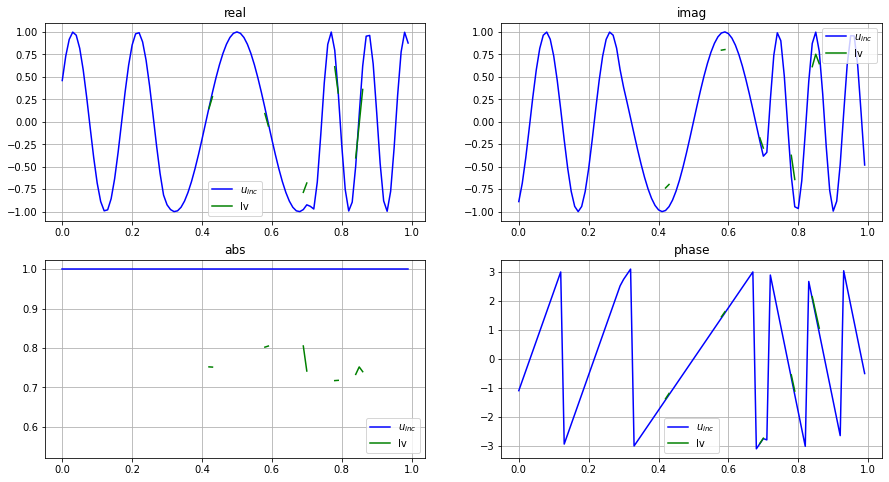

In [36]:
#
fig = plt.figure ( 0 , figsize = ( 15, 8 ) )

#real
ax = fig.add_subplot(221)#, projection='3d')
ax.plot(df["t"],np.real(df["uinc"]),color="blue",label="$u_{inc}$")
ax.plot(df["t"],np.real(df["trace"]),color="green",label="lv")
#ax.plot(df["t"],np.real(df["trace"]),color="red",label="trace")
plt.title("real")
plt.grid(True)
plt.legend()

#imag
ax = fig.add_subplot(222)#, projection='3d')
ax.plot(df["t"],np.imag(df["uinc"]),color="blue",label="$u_{inc}$")
ax.plot(df["t"],np.imag(df["trace"]),color="green",label="lv")
#ax.plot(df["t"],np.imag(df["trace"]),color="red",label="trace")
plt.title("imag")
plt.grid(True)
plt.legend()


#real
ax = fig.add_subplot(223)#, projection='3d')
ax.plot(df["t"],np.absolute(df["uinc"]),color="blue",label="$u_{inc}$")
ax.plot(df["t"],np.absolute(df["trace"]),color="green",label="lv")
#ax.plot(df["t"],np.real(df["trace"]),color="red",label="trace")
plt.title("abs")
plt.grid(True)
plt.legend()

#imag
ax = fig.add_subplot(224)#, projection='3d')
ax.plot(df["t"],np.angle(df["uinc"]),color="blue",label="$u_{inc}$")
ax.plot(df["t"],np.angle(df["trace"]),color="green",label="lv")
#ax.plot(df["t"],np.imag(df["trace"]),color="red",label="trace")
plt.title("phase")
plt.grid(True)
plt.legend()

plt.show()

## Herglotz

### Kernel

In [27]:
#definisco la dimensionaità:
sh = Bs.shape(1,1)
#sh.show()

#defiisco i knot vector
P=0 #polinomial degree
N=12 #base caridnality

#
#kv = Bs.uniform_open_kv(xmin,xmax,p=P,n=N)#Bs.knot_vector(P,N,v)
#kv = periodic_kv(xmin,xmax,p=P,n=N)
kv = Bs.periodic_kv(0.0,2*np.pi,p=P,n=N)
#kv.show()

#alloco la Bspline
kernel = Bs.Bspline(sh,[kv],properties={"periodic":[True],"dtype":np.complex})
#bs.show()

kernel.clear_cp()
kernel.set_cp(1,1)

True

In [28]:
#
NN = 1000
T = np.linspace(0.0,2*np.pi,NN,endpoint=False)
y   = kernel.evaluate(T)
#df = pd.DataFrame(xy)
#df = df.rename(columns={0:"x",1:"y"})

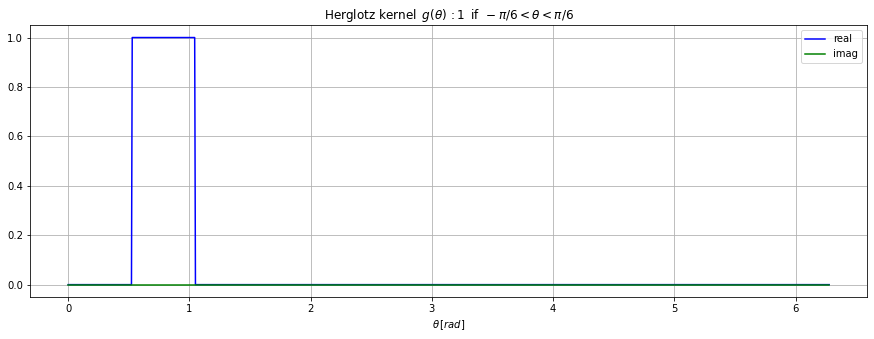

In [29]:
fig = plt.figure ( 0 , figsize = ( 15, 5 ) )

#real
ax = fig.add_subplot(111)#, projection='3d')
ax.plot(T,y.real,color="blue",label="real")
ax.plot(T,y.imag,color="green",label="imag")
plt.xlabel(r"$\theta \, \left[ rad \right]$")
plt.title(r"Herglotz kernel $\, g \left( \theta \right) \, : 1 \, $ if $ \,  - \pi/6 < \theta < \pi/6$")
plt.grid(True)
plt.legend()
plt.show()

In [30]:
def Herglotz_private(xy,kernel,k,NN):
    xy = np.asarray(xy)
    theta = np.linspace(0.,2*np.pi,NN,endpoint=False)
    cos = np.cos(theta)
    sin = np.sin(theta)
    g = kernel(theta)
    phase = np.outer(xy[:,0],cos) + np.outer(xy[:,1],sin)
    expo = np.exp(1.j*phase*k)
    return np.dot(expo,g)/NN

In [31]:
#k = 30./4.
NN = 100
def Herglotz(xy): 
    return Herglotz_private(xy,kernel,wavevector,NN)

In [32]:
Nx= int(xmax-xmin)*20
Ny = int(ymax-ymin)*20
x = np.linspace(xmin,xmax,Nx)
y = np.linspace(ymin,ymax,Ny)
X,Y = np.meshgrid(x,y)

XY = np.zeros((Nx*Ny,2))
XY[:,0] = X.reshape((Nx*Ny,))
XY[:,1] = Y.reshape((Nx*Ny,))

x = XY[:,0]
y = XY[:,1]

In [33]:
Uinc = Herglotz(XY)

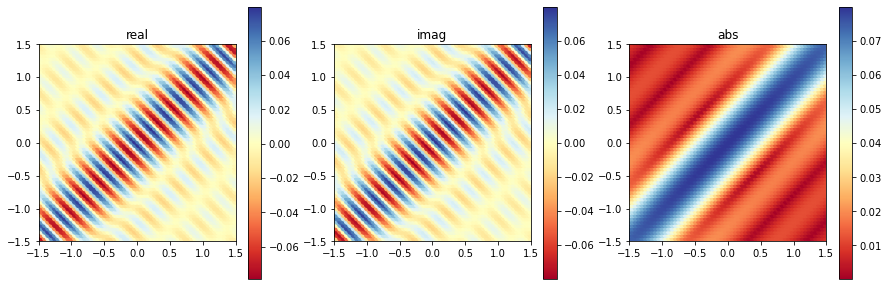

In [34]:
#
fig = plt.figure ( 0 , figsize = ( 15 , 5 ) )

cmap = 'RdYlBu'

ax = fig.add_subplot(131)
#ax.plot(xB, yB, color= "black",label="Bspline")
sc = ax.scatter(x,y,c=Uinc.real,cmap=cmap)
plt.colorbar(sc)
ax.set_aspect('equal')
plt.xlim(min(x),max(x))
plt.ylim(min(y),max(y))
plt.title("real")

ax = fig.add_subplot(132)
#ax.plot(xB, yB, color= "black",label="Bspline")
sc = ax.scatter(x,y,c=Uinc.imag,cmap=cmap)
plt.colorbar(sc)
ax.set_aspect('equal')
plt.xlim(min(x),max(x))
plt.ylim(min(y),max(y))
plt.title("imag")

ax = fig.add_subplot(133)
#ax.plot(xB, yB, color= "black",label="Bspline")
sc = ax.scatter(x,y,c=np.absolute(Uinc),cmap=cmap)
plt.colorbar(sc)
ax.set_aspect('equal')
plt.xlim(min(x),max(x))
plt.ylim(min(y),max(y))
plt.title("abs")

#ax = fig.add_subplot(224)
##ax.plot(xB, yB, color= "black",label="Bspline")
#sc = ax.scatter(x,y,c=np.angle(Uinc),cmap=cmap)
#plt.colorbar(sc)
#ax.set_aspect('equal')
#plt.xlim(min(x),max(x))
#plt.ylim(min(y),max(y))
#plt.title("phase")

plt.show()

### Preparation

In [35]:
Nx= int(xmax-xmin)*20
Ny = int(ymax-ymin)*20
x = np.linspace(xmin,xmax,Nx)
y = np.linspace(ymin,ymax,Ny)
X,Y = np.meshgrid(x,y)

XY0 = np.zeros((Nx*Ny,2))
XY0[:,0] = X.reshape((Nx*Ny,))
XY0[:,1] = Y.reshape((Nx*Ny,))

internal = bs.internal_points(XY=XY0,NN=1000,xmin=0.,xmax=1.,opts=None)
XY = XY0[ np.logical_not(internal) ]

In [36]:
#
NN = 1000
T = np.linspace(xminBs,xmaxBs,NN,endpoint=True)
xy   = bs.evaluate(T)
uinc = Herglotz(xy)

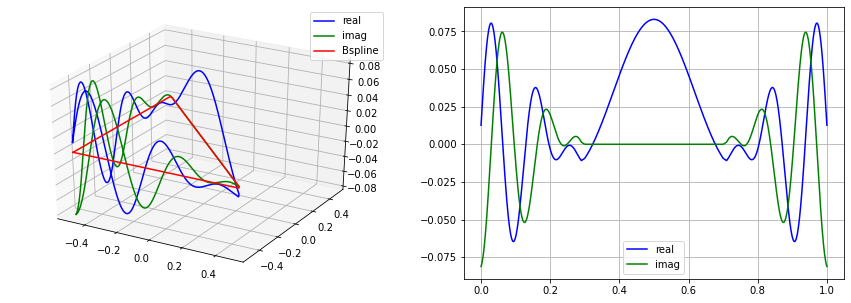

In [37]:
#
fig = plt.figure ( 0 , figsize = ( 15, 5 ) )

#
#s = 0.2
ax = fig.add_subplot(121, projection='3d')
ax.plot(xy[:,0], xy[:,1],uinc.real,color="blue",label="real")
ax.plot(xy[:,0], xy[:,1],uinc.imag,color="green",label="imag")
ax.plot(xy[:,0], xy[:,1],0.0,color="red",label="Bspline")
plt.grid(True)
plt.legend()

#
ax = fig.add_subplot(122)#, projection='3d')
ax.plot(T,uinc.real,color="blue",label="real")
ax.plot(T,uinc.imag,color="green",label="imag")
plt.grid(True)
plt.legend()

#
#ax = fig.add_subplot(133)#, projection='3d')
#ax.plot(T,somma.real,color="blue",label="real")
#ax.plot(T,somma.imag,color="green",label="imag")
#plt.grid(True)
#plt.legend()

plt.show()

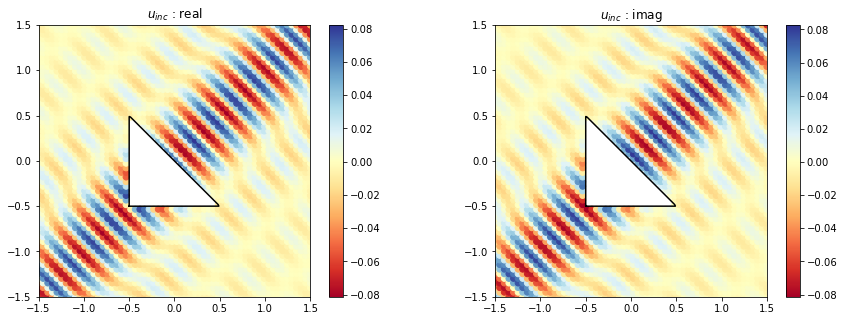

In [38]:
#
fig = plt.figure ( 0 , figsize = ( 15 , 5 ) )

Uinc = Herglotz(XY)

cmap = 'RdYlBu'
    
plot(fig,121,df["x"], df["y"],XY[:,0],XY[:,1],Uinc.real,"$u_{inc}$ : real",cmap)
plot(fig,122,df["x"], df["y"],XY[:,0],XY[:,1],Uinc.imag,"$u_{inc}$ : imag",cmap)

plt.show()

### Solution

In [39]:
file_sol = file_dir+"solution-Herglotz-"+suffix
file_lv  = file_dir+"load_vector-Herglotz-"+suffix
file_ind = file_dir+"indirect_solution-Herglotz-"+suffix
print(file_sol)
print(file_lv)
print(file_ind)

files/BEM/triangle-periodic/solution-Herglotz-P=1-N=100-k=20.0.csv
files/BEM/triangle-periodic/load_vector-Herglotz-P=1-N=100-k=20.0.csv
files/BEM/triangle-periodic/indirect_solution-Herglotz-P=1-N=100-k=20.0.csv


In [40]:
#
READ = False
SAVE = True
if os.path.exists(file_sol) and READ == True :
    sol,Xnp,Valnp = bs.load("sol-BEM",file_sol)
    
if os.path.exists(file_lv) and READ == True :
    lv = bs.load("lv-BEM",file_lv)
    
if os.path.exists(file_ind) and READ == True :
    sol = bs.load("ind_sol-BEM",file_ind)
    
else :
    opts = {"print":True,"ready_sol_BEM":False,"ready_lv_BEM":False,"ready_ind_sol_BEM":False}
    sol,Xnp,Valnp = bs.BEM(uinc=Herglotz,k=wavevector,XY=XY,opts=opts)
    if SAVE == True :
        bs.save("sol-BEM",file_sol)
        bs.save("lv-BEM",file_lv)
        bs.save("ind_sol-BEM",file_ind)
sol.head()

single_layer_potential_basis_BEM


,x,value
"(-1.5, -1.5)","(-1.5, -1.5)",0.008196-0.004085j
"(-1.4491525423728813, -1.5)","(-1.4491525423728813, -1.5)",0.003565-0.008548j
"(-1.3983050847457628, -1.5)","(-1.3983050847457628, -1.5)",-0.002799-0.008969j
"(-1.347457627118644, -1.5)","(-1.347457627118644, -1.5)",-0.007961-0.005301j
"(-1.2966101694915255, -1.5)","(-1.2966101694915255, -1.5)",-0.009742+0.000731j


In [41]:
#
Uinc = Herglotz(XY)#.reshape(Nx,Ny).transpose()
total = Uinc + Valnp

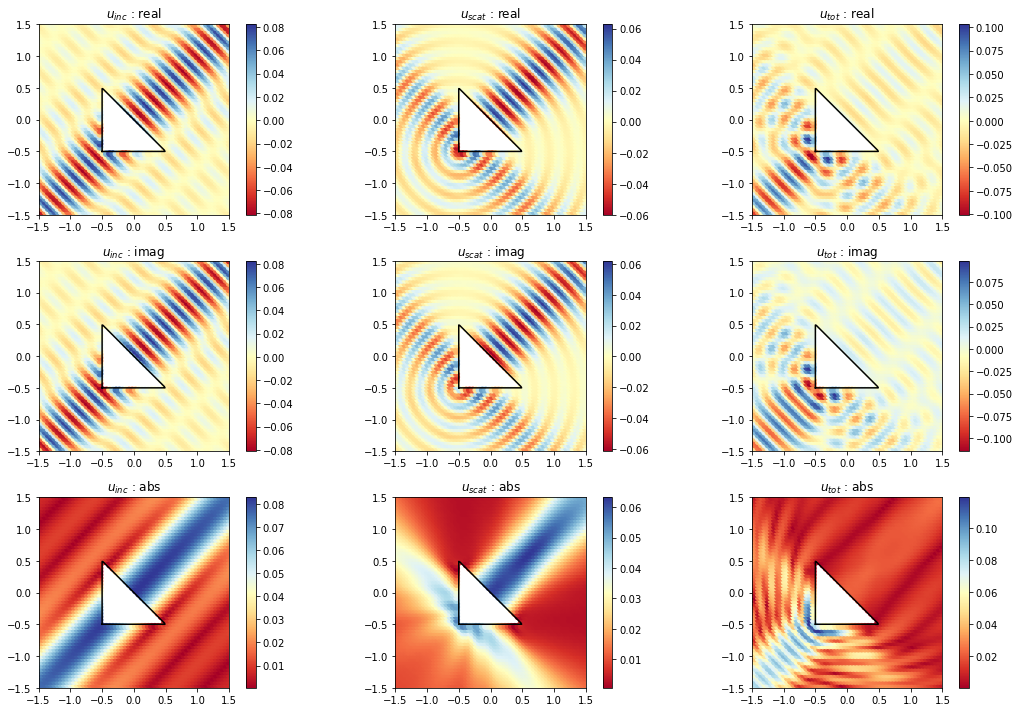

In [42]:
#grafico
fig = plt.figure ( 0 , figsize = ( 15 , 10 ) )

cmap = 'RdYlBu'

    
plot_sol(fig,331,df["x"], df["y"],XY[:,0],XY[:,1],Uinc.real,"$u_{inc}$ : real")
plot_sol(fig,334,df["x"], df["y"],XY[:,0],XY[:,1],Uinc.imag,"$u_{inc}$ : imag")
plot_sol(fig,337,df["x"], df["y"],XY[:,0],XY[:,1],np.absolute(Uinc),"$u_{inc}$ : abs")

plot_sol(fig,332,df["x"], df["y"],XY[:,0],XY[:,1],Valnp.real,"$u_{scat}$ : real")
plot_sol(fig,335,df["x"], df["y"],XY[:,0],XY[:,1],Valnp.imag,"$u_{scat}$ : imag")
plot_sol(fig,338,df["x"], df["y"],XY[:,0],XY[:,1],np.absolute(Valnp),"$u_{scat}$ : abs")

plot_sol(fig,333,df["x"], df["y"],XY[:,0],XY[:,1],total.real,"$u_{tot}$ : real")
plot_sol(fig,336,df["x"], df["y"],XY[:,0],XY[:,1],total.imag,"$u_{tot}$ : imag")
plot_sol(fig,339,df["x"], df["y"],XY[:,0],XY[:,1],np.absolute(total),"$u_{tot}$ : abs")

plt.tight_layout()

sol_png = file_dir+"solution-n=6-random=False-"+suffix_png
plt.savefig(sol_png)

plt.show()